In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-28 10:56:23.903614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 10:56:24.104472: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-28 10:56:24.765085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

,DA,DB,bA,bB,bC,bD,bE,bF,VA,VB,...,nfe,nee,neb,nce,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion
404,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,615.268976,73.210081,...,4.0,4.0,4.0,1.0,2.0,"[0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....",stable spiral,turing I oscillatory,0.004898+0.036487j,True
2726,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,228.017071,94.502643,...,4.0,4.0,4.0,1.0,2.0,"[83.3645, 0.276, 12736.8586, 66.0485, 579.5646...",stable spiral,turing I oscillatory,0.000114+0.002647j,True
3508,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,23.538028,320.885489,...,4.0,4.0,4.0,1.0,3.0,"[6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....",stable spiral,turing I oscillatory,0.001639+0.132134j,True
7516,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,16.205693,83.166774,...,4.0,4.0,4.0,1.0,1.0,"[1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...",stable spiral,turing I oscillatory,0.000652+0.003066j,True
7883,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,85.164519,738.495294,...,4.0,4.0,4.0,1.0,2.0,"[2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....",stable spiral,turing I oscillatory,0.001346+0.016362j,True


In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [20]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
dxdy = x_size*y_size/L**2
N = x_size*y_size    
t_star = np.arange(0, T)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]

x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)

#data = data[:, x_slice, y_slice, np.newaxis]
#x_size = data.shape[1]
#y_size = data.shape[2]
#T = 1#data.shape[3]



indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])



In [21]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

In [22]:
def create_dataset_multi_nodes(
    data,
    t_star,
    N,
    T,
    L,
    training_data_size,
    pde_data_size,    
    signal_to_noise=0,
    shuffle=True,
    derivatives=None,
    idx_data=None,
):
    x_size = data.shape[1]
    y_size = data.shape[2]
    x_domain = L * np.linspace(0, 1, x_size)
    y_domain = L * np.linspace(0, 1, y_size)

    X, Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
    XX = np.tile(X.flatten(), T)  # N x T
    YY = np.tile(Y.flatten(), T)  # N x T
    TT = np.repeat(t_star[-T:], N)  # T x N

    #UU = np.einsum("cijk->ckij", data[:, :, :, -T:])
    UU = np.einsum("cxyk->ckxy", data[:, :, :, -T:])
    UU = np.array([UU[i, :, :, :].flatten() for i in range(UU.shape[0])])  # c , N x T
    
    if derivatives is not None:
        dds = np.array([[np.einsum("ijk->kij", d[i, :, :, -T:]).flatten() for d in derivatives]
               for i in range(derivatives[0].shape[0])
              ])                  
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_u = (np.max(UU) - np.min(UU)) / 2.0
        sigma_u = signal_amp_u * signal_to_noise
    # Observed data
    if idx_data is None:
        if shuffle:
            idx_data = np.random.choice(N * T, training_data_size, replace=False)
        else:
            idx_data = list(range(training_data_size))
    # PDE colocations
    if shuffle:
        idx_pde = np.random.choice(N * T, pde_data_size, replace=False)
    else:
        idx_pde = list(range(pde_data_size))

    # Lower/Upper bounds
    lb, ub = lower_upper_bounds(np.c_[XX, YY, TT])
    if derivatives is not None:
        derivatives_lb_ub = [
            lower_upper_bounds(dd.T) for dd in dds
        ]        

    ret = {
        "obs_input": np.c_[XX[idx_data], YY[idx_data], TT[idx_data]],
        "obs_output": np.vstack([UU[i, idx_data] for i in range(UU.shape[0])]).T,
        "pde": np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]],
        "lb": lb,
        "ub": ub,
    }
    if derivatives is not None:
        ret = {
            **ret,
            **{
                "ders": dds[:, :, idx_data],
                "derivatives_lb_ub": derivatives_lb_ub,
            },
        }
    if signal_to_noise > 0:
        ret["obs_output"] += sigma_u * np.random.randn(len(idx_data))

    return ret

In [23]:
data.shape

(6, 160, 160, 1)

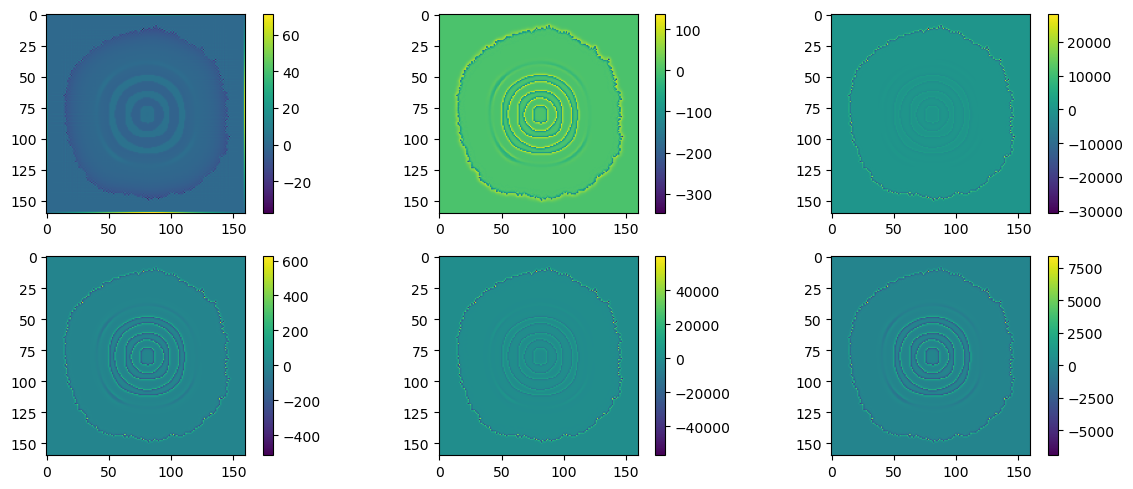

In [24]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


In [25]:
c_xx.shape

(6, 160, 160, 1)

In [26]:
data.shape

(6, 160, 160, 1)

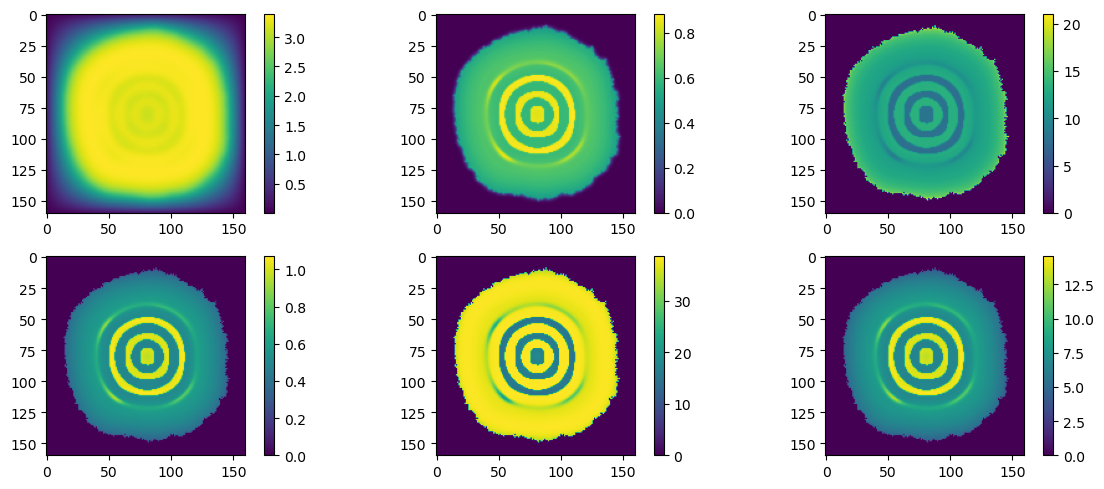

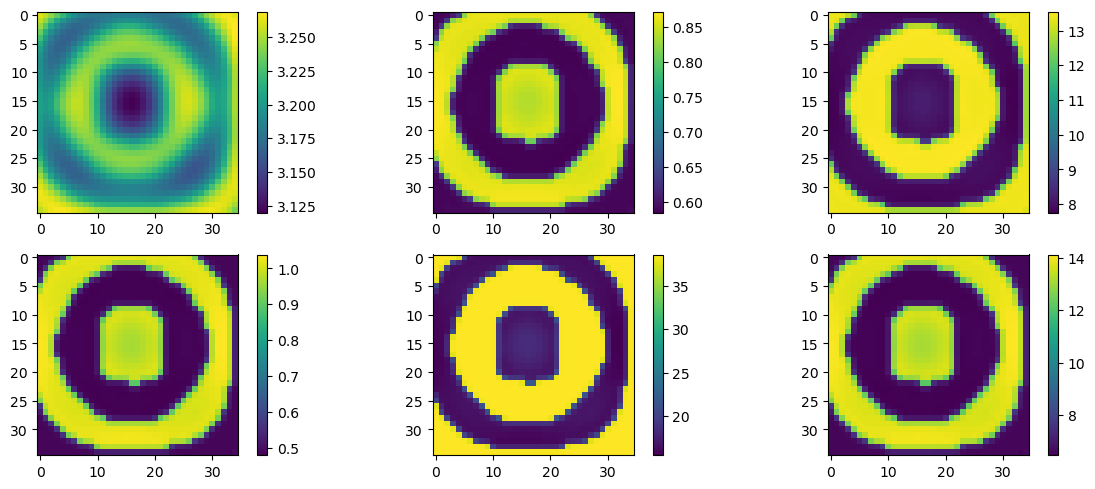

In [27]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [28]:
c_xx.shape

(6, 160, 160, 1)

In [29]:
c_restricted = data[:, x_slice, y_slice, :].copy()
c_xx_restricted = c_xx[:, x_slice, y_slice, :].copy()
c_yy_restricted = c_yy[:, x_slice, y_slice, :].copy() 
c_t_restricted = c_t[:, x_slice, y_slice, :].copy()

    
model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}


dataset = create_dataset_multi_nodes(data, t_star, N, 1, L, **model_params)
lb = dataset['lb'][0:2]
ub = dataset['ub'][0:2]
obs_X = np.float32(dataset['obs_input'][:, 0:2])
obs_Y = np.float32(dataset['obs_output'])
#pde_X = np.float32(dataset['pde'])
ders_xx = np.float32(dataset['ders'][:, 0, :])
ders_yy = np.float32(dataset['ders'][:, 1, :])
ders_t = np.float32(dataset['ders'][:, 2, :])

In [30]:
A.shape

(160, 160)

In [31]:
obs_X.shape

(1225, 2)

In [384]:
4225/65

65.0

In [32]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)

def create_tf_var(name, value, no_clip=False):
    print(f"{name}: {value}")
    if no_clip:
        return tf.Variable(value,
                       dtype=pinn.dtype,
                       name=name)
    else:
        return tf.Variable(value,
                       dtype=pinn.dtype,
                       name=name,
                       constraint=clip_by_value_zero_lb)
    
    
    
#lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
#ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn = tu.NN_Scaled([2, 128, 128, 6], lb, ub, tf.float32)
#optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
optimizer=keras.optimizers.Adam(learning_rate=1e-2)

DA = create_tf_var("D_u", df_params.loc[ID,:].DA)    
DB = create_tf_var("D_v", df_params.loc[ID,:].DB)
bA = create_tf_var("bA", 0)#df_params.loc[ID,:].bA)#
bB = create_tf_var("bB", 0)#df_params.loc[ID,:].bB)#
bC = create_tf_var("bC", 0)#df_params.loc[ID,:].bC)#
bD = create_tf_var("bD", 0)#df_params.loc[ID,:].bD)#
bE = create_tf_var("bE", 0)#df_params.loc[ID,:].bE)#
bF = create_tf_var("bF", 0)#df_params.loc[ID,:].bF)#
VA = create_tf_var("VA", 0)#df_params.loc[ID,:].VA)
VB = create_tf_var("VB", 0)#df_params.loc[ID,:].VB)
VC = create_tf_var("VC", 0)#df_params.loc[ID,:].VC)
VD = create_tf_var("VD", 0)#df_params.loc[ID,:].VD)
VE = create_tf_var("VE", 0)#df_params.loc[ID,:].VE)
VF = create_tf_var("VF", 0)#df_params.loc[ID,:].VF)
Kab = create_tf_var("Kab", df_params.loc[ID,:].Kab)
Kbd = create_tf_var("Kbd", df_params.loc[ID,:].Kbd)
Kce = create_tf_var("Kce", df_params.loc[ID,:].Kce)
Kda = create_tf_var("Kda", df_params.loc[ID,:].Kda)
Keb = create_tf_var("Keb", df_params.loc[ID,:].Keb)
Kee = create_tf_var("Kee", df_params.loc[ID,:].Kee)
Kfe = create_tf_var("Kfe", df_params.loc[ID,:].Kfe)
muASV = create_tf_var("muASV", df_params.loc[ID,:].muASV)
muLVA = create_tf_var("muLVA", df_params.loc[ID,:].muLVA)
nab = create_tf_var("nab", df_params.loc[ID,:].nab)
nbd = create_tf_var("nbd", df_params.loc[ID,:].nbd)
nce = create_tf_var("nce", df_params.loc[ID,:].nce)
nda = create_tf_var("nda", df_params.loc[ID,:].nda)
nfe = create_tf_var("nfe", df_params.loc[ID,:].nfe)
neb = create_tf_var("neb", df_params.loc[ID,:].neb)
nee = create_tf_var("nee", df_params.loc[ID,:].nee)



@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = pinn.trainable_variables + (
            bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF)


        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)

            outputs = pinn.net(H)
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, H)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]

            grad_B = tape2.gradient(Bg, H)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            

        grad_A_x = tape.gradient(A_x, H)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, H)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, H)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, H)
        B_yy = grad_B_y[:, 1]

        A = tf.squeeze(elements[1][:, 0])
        B = tf.squeeze(elements[1][:, 1])
        C = tf.squeeze(elements[1][:, 2])
        D = tf.squeeze(elements[1][:, 3])
        E = tf.squeeze(elements[1][:, 4])
        F = tf.squeeze(elements[1][:, 5]) 
        
        act_A_xx = elements[2][:, 0]
        act_B_xx = elements[2][:, 1]
        act_A_yy = elements[3][:, 0]
        act_B_yy = elements[3][:, 1]
        
        act_A_t = elements[4][:, 0]
        act_B_t = elements[4][:, 1]
        act_C_t = elements[4][:, 2]
        act_D_t = elements[4][:, 3]
        act_E_t = elements[4][:, 4]
        act_F_t = elements[4][:, 5]
        
        
        def activate(x, km, n=2):
            # ex = (km / (x + 1e-20)) ** (n)
            # tf.math.is_inf(ex)
            act = 1 / (1 + (km / (x + 1e-20)) ** (n))
            return act

        def inhibit(x, km, n=2):
            inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
            return inh
        
        A_rhs = DA * (A_xx + A_yy)# - u_t
        B_rhs = DB * (B_xx + B_yy)# - v_t

        f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
        f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
        f_C =  -act_C_t - bC - VC * inhibit(D, Kda, nda) + muLVA * C
        f_D =  -act_D_t - bD - VD * activate(B, Kbd, nbd) + muLVA * D
        f_E =  -act_E_t - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
        f_F =  -act_F_t - bF - VF * activate(B, Kbd, nbd) + muLVA * F
                
        l2_res_A = tf.reduce_sum(f_A**2)
        l2_res_B = tf.reduce_sum(f_B**2)
        l2_res_C = tf.reduce_sum(f_C**2)
        l2_res_D = tf.reduce_sum(f_D**2)
        l2_res_E = tf.reduce_sum(f_E**2)
        l2_res_F = tf.reduce_sum(f_F**2)

        act_A_rhs = DA*(act_A_xx + act_A_yy) - act_A_t
        act_B_rhs = DB*(act_B_xx + act_B_yy) - act_B_t

        l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
        l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


        l2 = (l2_res_A + l2_res_B + l2_res_C + l2_res_D + 100*l2_res_E + 100*l2_res_F +  
              l2_res_A_rhs + l2_res_B_rhs)
        #l2 = l2_res_A + l2_res_B  + l2_res_A_rhs + l2_res_B_rhs
        # l2 = l2_res_A_rhs + l2_res_B_rhs

    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
            l2_res_A_rhs, l2_res_B_rhs)

D_u: 1.0
D_v: 0.001
bA: 0
bB: 0
bC: 0
bD: 0
bE: 0
bF: 0
VA: 0
VB: 0
VC: 0
VD: 0
VE: 0
VF: 0
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 4.247713917996289
muLVA: 1.4288264760159275
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0


In [33]:
names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

def print_callback(printer, losses, epoch):
     
    printer(f"at epoch {epoch:d}, "
            f" total loss: {np.sum(losses)}")
    printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)])) 
    printer(f"bA: {bA.numpy()}, bB: {bB.numpy()},"
           f"bC: {bC.numpy()}, bD: {bD.numpy()} \n"
           f"bE: {bE.numpy()}, bF: {bF.numpy()}, "
           f"VA: {VA.numpy()}, VB: {VB.numpy()}\n"
           f"VC: {VC.numpy()}, VD: {VD.numpy()}, "
           f"VE: {VE.numpy()}, VF: {VF.numpy()}\n")

In [34]:
def gen_series():    
    
    for i in range(obs_X.shape[0]):        
        yield obs_X[i,:], obs_Y[i,:], ders_xx[:, i], ders_yy[:, i], ders_t[:, i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((obs_X.shape[1],),(obs_Y.shape[1],),
                                                   (ders_xx.shape[0],),(ders_yy.shape[0],),
                                                   (ders_t.shape[0],)))

In [35]:
epochs=100000+1
params_est = np.zeros((epochs, 12))
def epoch_callback(epoch, loss_samples, index):
    params_est[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy())


In [36]:
obs_X.shape

(1225, 2)

In [507]:
4225/5

845.0

In [37]:
losses = tu.train(epochs=epochs,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 8,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=epoch_callback)


Start of epoch 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-28 10:59:35.719277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-28 10:59:35.742741: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6210006940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-28 10:59:35.742785: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-02-28 10:59:35.749333: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-28 10:59:36.115942: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0,  total loss: 3025390.129527569
l2_res_A: 227720.09375000, l2_res_B: 12052.00488281, l2_res_C: 295548.84375000, l2_res_D: 1571.37414551, l2_res_E: 2186810.25000000, l2_res_F: 289459.37500000, l2_res_A_rhs: 12224.18750000, l2_res_B_rhs: 4.00049925
bA: 0.010000230744481087, bB: 0.010000230744481087,bC: 0.010000230744481087, bD: 0.010000230744481087 
bE: 0.010000229813158512, bF: 0.010000231675803661, VA: 0.010000230744481087, VB: 0.010000230744481087
VC: 0.010000230744481087, VD: 0.010000230744481087, VE: 0.010000230744481087, VF: 0.010000229813158512

Time taken: 10.21s

Start of epoch 1000
at epoch 1000,  total loss: 1484953.097793579
l2_res_A: 6781.33056641, l2_res_B: 214.82666016, l2_res_C: 42837.94140625, l2_res_D: 127.90221405, l2_res_E: 1352385.87500000, l2_res_F: 73989.62500000, l2_res_A_rhs: 8574.27929688, l2_res_B_rhs: 41.31764984
bA: 7.1406755447387695, bB: 2.9420876502990723,bC: 7.850144863128662, bD: 0.9800118803977966 
bE: 9.409101486206055, bF: 8.268062591552734


Start of epoch 15000
at epoch 15000,  total loss: 232313.05279786617
l2_res_A: 922.69714355, l2_res_B: 9.44937801, l2_res_C: 0.02251380, l2_res_D: 0.00018229, l2_res_E: 211803.96875000, l2_res_F: 18376.38085938, l2_res_A_rhs: 1188.95092773, l2_res_B_rhs: 11.58304310
bA: 2.367781639099121, bB: 0.957785964012146,bC: 0.010753658600151539, bD: 0.01000769343227148 
bE: 34.1474609375, bF: 11.615769386291504, VA: 38.33653259277344, VB: 93.27401733398438
VC: 53.675071716308594, VD: 44.231346130371094, VE: 126.4344253540039, VF: 123.17510986328125

Time taken: 42.54s

Start of epoch 16000
at epoch 16000,  total loss: 226444.42167305248
l2_res_A: 1017.83819580, l2_res_B: 6.42266178, l2_res_C: 0.02251376, l2_res_D: 0.00018201, l2_res_E: 206707.37500000, l2_res_F: 17636.55859375, l2_res_A_rhs: 1067.76586914, l2_res_B_rhs: 8.43865681
bA: 2.3396201133728027, bB: 0.7801756858825684,bC: 0.010727808810770512, bD: 0.01000993326306343 
bE: 33.73316955566406, bF: 11.37967586517334, VA: 38.44938659667969,


Start of epoch 30000
at epoch 30000,  total loss: 152779.92164345479
l2_res_A: 957.61621094, l2_res_B: 2.01771307, l2_res_C: 0.02251349, l2_res_D: 0.00018201, l2_res_E: 141989.89062500, l2_res_F: 8902.70507812, l2_res_A_rhs: 925.71630859, l2_res_B_rhs: 1.95301223
bA: 2.144324779510498, bB: 0.11610084772109985,bC: 0.01068818662315607, bD: 0.010010446421802044 
bE: 27.958192825317383, bF: 8.087984085083008, VA: 39.137062072753906, VB: 130.0632781982422
VC: 53.6753044128418, VD: 44.2313346862793, VE: 274.4728088378906, VF: 269.64263916015625

Time taken: 42.20s

Start of epoch 31000
at epoch 31000,  total loss: 148127.14419837025
l2_res_A: 928.64636230, l2_res_B: 2.01555872, l2_res_C: 0.02252612, l2_res_D: 0.00018201, l2_res_E: 137835.35937500, l2_res_F: 8394.95507812, l2_res_A_rhs: 964.16790771, l2_res_B_rhs: 1.97720838
bA: 2.1332247257232666, bB: 0.11654185503721237,bC: 0.010862268507480621, bD: 0.010010614059865475 
bE: 27.5463924407959, bF: 7.855039119720459, VA: 39.16777801513672, V


Start of epoch 45000
at epoch 45000,  total loss: 90967.65241221525
l2_res_A: 871.17205811, l2_res_B: 1.98895967, l2_res_C: 0.02251341, l2_res_D: 0.00218811, l2_res_E: 86242.26562500, l2_res_F: 2883.57739258, l2_res_A_rhs: 966.50482178, l2_res_B_rhs: 2.11885357
bA: 2.0922718048095703, bB: 0.11023111641407013,bC: 0.010690043680369854, bD: 0.009914033114910126 
bE: 21.79123878479004, bF: 4.6072306632995605, VA: 39.322425842285156, VB: 130.3530731201172
VC: 53.6753044128418, VD: 44.23124694824219, VE: 422.0479736328125, VF: 414.15478515625

Time taken: 42.57s

Start of epoch 46000
at epoch 46000,  total loss: 87477.32126061704
l2_res_A: 931.97723389, l2_res_B: 2.04258823, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 83021.14843750, l2_res_F: 2603.50732422, l2_res_A_rhs: 916.51440430, l2_res_B_rhs: 2.10857677
bA: 2.093013286590576, bB: 0.11094723641872406,bC: 0.010689248330891132, bD: 0.01000995747745037 
bE: 21.380762100219727, bF: 4.378268718719482, VA: 39.328033447265625, VB: 


Start of epoch 60000
at epoch 60000,  total loss: 46570.22048060536
l2_res_A: 900.46166992, l2_res_B: 2.02663183, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 44510.39843750, l2_res_F: 222.42152405, l2_res_A_rhs: 932.71826172, l2_res_B_rhs: 2.17125988
bA: 2.075955390930176, bB: 0.1094420775771141,bC: 0.010689250193536282, bD: 0.01001013908535242 
bE: 15.657584190368652, bF: 1.2866607904434204, VA: 39.38440704345703, VB: 130.35952758789062
VC: 53.67530059814453, VD: 44.23133850097656, VE: 568.8252563476562, VF: 552.0213623046875

Time taken: 42.49s

Start of epoch 61000
at epoch 61000,  total loss: 44211.47433400281
l2_res_A: 891.69091797, l2_res_B: 2.00363374, l2_res_C: 0.02257695, l2_res_D: 0.00018201, l2_res_E: 42219.09765625, l2_res_F: 157.41198730, l2_res_A_rhs: 939.06903076, l2_res_B_rhs: 2.17834902
bA: 2.07244873046875, bB: 0.10875725746154785,bC: 0.010515022091567516, bD: 0.01001013908535242 
bE: 15.249500274658203, bF: 1.0839656591415405, VA: 39.393707275390625, VB: 1


Start of epoch 75000
at epoch 75000,  total loss: 18514.063577574285
l2_res_A: 883.30377197, l2_res_B: 2.02660084, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 16684.87304688, l2_res_F: 0.03405499, l2_res_A_rhs: 941.63854980, l2_res_B_rhs: 2.16485739
bA: 2.0734403133392334, bB: 0.1096528172492981,bC: 0.010689242742955685, bD: 0.01000985223799944 
bE: 9.589675903320312, bF: 0.010143489576876163, VA: 39.393070220947266, VB: 130.41824340820312
VC: 53.67530059814453, VD: 44.23133850097656, VE: 714.0226440429688, VF: 605.0210571289062

Time taken: 42.47s

Start of epoch 76000
at epoch 76000,  total loss: 17146.62763304441
l2_res_A: 915.24414062, l2_res_B: 2.01432633, l2_res_C: 0.02251348, l2_res_D: 0.00018211, l2_res_E: 15319.29394531, l2_res_F: 0.03405489, l2_res_A_rhs: 907.86749268, l2_res_B_rhs: 2.15097761
bA: 2.07393479347229, bB: 0.10835550725460052,bC: 0.010688175447285175, bD: 0.010008194483816624 
bE: 9.189438819885254, bF: 0.010137360543012619, VA: 39.390464782714844, VB:


Start of epoch 90000
at epoch 90000,  total loss: 4313.049493468308
l2_res_A: 922.90429688, l2_res_B: 2.07723761, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 2481.21899414, l2_res_F: 0.03405499, l2_res_A_rhs: 904.63507080, l2_res_B_rhs: 2.15714335
bA: 2.0835647583007812, bB: 0.10829515010118484,bC: 0.010689232498407364, bD: 0.010010049678385258 
bE: 3.703498363494873, bF: 0.010135927237570286, VA: 39.34814453125, VB: 130.4359893798828
VC: 53.67530059814453, VD: 44.23134231567383, VE: 854.8811645507812, VF: 605.0209350585938

Time taken: 42.56s

Start of epoch 91000
at epoch 91000,  total loss: 3830.225773384969
l2_res_A: 933.59130859, l2_res_B: 2.03633928, l2_res_C: 0.02251370, l2_res_D: 0.00018201, l2_res_E: 2002.10449219, l2_res_F: 0.03827370, l2_res_A_rhs: 890.32531738, l2_res_B_rhs: 2.10734653
bA: 2.0722315311431885, bB: 0.10653181374073029,bC: 0.010689245536923409, bD: 0.010009780526161194 
bE: 3.3276422023773193, bF: 0.009599057957530022, VA: 39.39057159423828, VB: 130

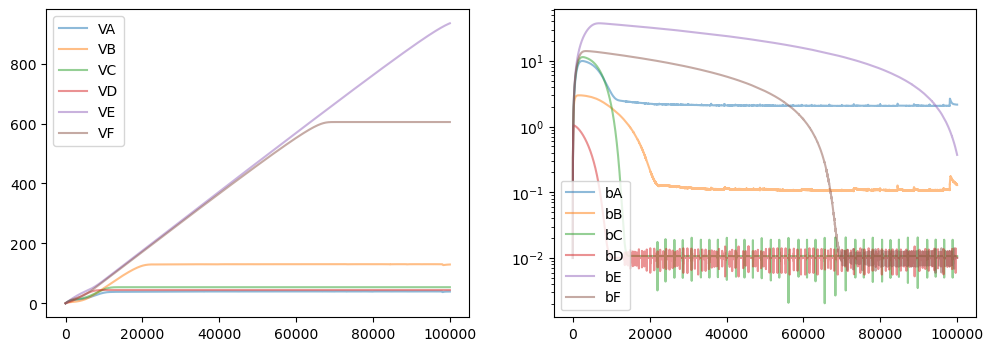

In [38]:
param_name = ["bA", "bB", "bC", "bD", "bE", "bF", "VA", "VB", "VC", "VD", "VE", "VF"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est[-1,i] > 10:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est[-1,i] <= 10:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

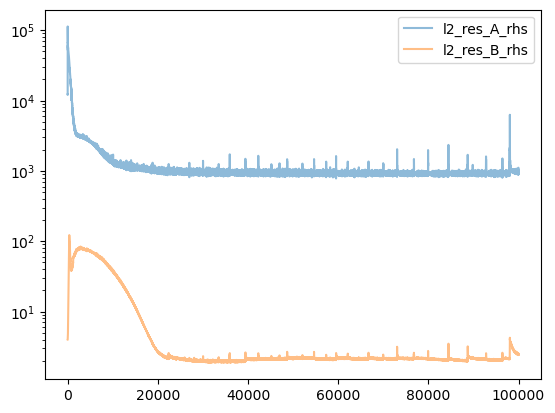

In [39]:
for i, n in enumerate(names[-2:]):
    plt.plot(losses[:,6+i], label=n, alpha=.5)
        
plt.legend()
plt.yscale('log')
plt.show()

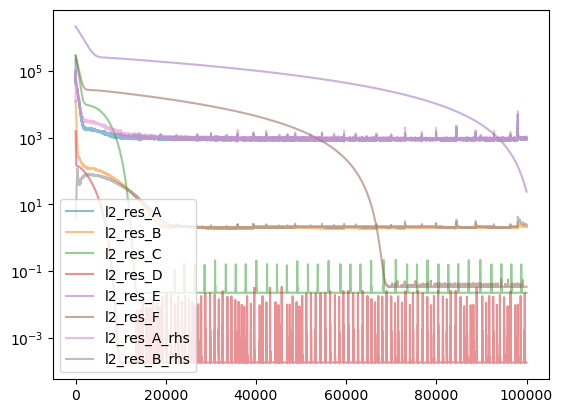

In [40]:
for i, n in enumerate(names):
    plt.plot(losses[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

In [44]:
optimizer.lr.assign(1e-3)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [45]:
epochs2=50000+1
params_est2 = np.zeros((epochs2, 12))
def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy())

In [46]:
losses2 = tu.train(epochs=epochs2,
                  batch_size=4225,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 8,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=epoch_callback2)


Start of epoch 0
at epoch 0,  total loss: 1919.744454927175
l2_res_A: 970.40081787, l2_res_B: 2.18130112, l2_res_C: 0.02251370, l2_res_D: 0.00018201, l2_res_E: 24.22173691, l2_res_F: 0.03405489, l2_res_A_rhs: 920.44885254, l2_res_B_rhs: 2.43499589
bA: 2.156648874282837, bB: 0.1289452463388443,bC: 0.01068924181163311, bD: 0.01001013908535242 
bE: 0.37061837315559387, bF: 0.010136467404663563, VA: 39.10065460205078, VB: 129.46844482421875
VC: 53.67530059814453, VD: 44.23133850097656, VE: 934.6361694335938, VF: 605.02099609375

Time taken: 0.79s

Start of epoch 1000
at epoch 1000,  total loss: 1905.5638972812885
l2_res_A: 930.09594727, l2_res_B: 2.13014269, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 21.02450371, l2_res_F: 0.03405498, l2_res_A_rhs: 949.82678223, l2_res_B_rhs: 2.42977071
bA: 2.143585443496704, bB: 0.1278361976146698,bC: 0.010689247399568558, bD: 0.010010138154029846 
bE: 0.34537050127983093, bF: 0.01013600081205368, VA: 39.14476013183594, VB: 129.5391387939453
V


Start of epoch 15000
at epoch 15000,  total loss: 1832.3536703938153
l2_res_A: 911.06524658, l2_res_B: 2.00503755, l2_res_C: 0.02251368, l2_res_D: 0.00018713, l2_res_E: 0.53477907, l2_res_F: 0.03405501, l2_res_A_rhs: 916.56927490, l2_res_B_rhs: 2.12257648
bA: 2.0847041606903076, bB: 0.11972665786743164,bC: 0.01068924367427826, bD: 0.010110284201800823 
bE: 0.009874005801975727, bF: 0.010137581266462803, VA: 39.35258483886719, VB: 129.88522338867188
VC: 53.67530059814453, VD: 44.231449127197266, VE: 943.268310546875, VF: 605.0209350585938

Time taken: 42.43s

Start of epoch 16000
at epoch 16000,  total loss: 1830.9745839694224
l2_res_A: 924.45166016, l2_res_B: 2.01449990, l2_res_C: 0.02251370, l2_res_D: 0.00018201, l2_res_E: 0.53477401, l2_res_F: 0.03405499, l2_res_A_rhs: 901.81500244, l2_res_B_rhs: 2.10189676
bA: 2.082367420196533, bB: 0.11939920485019684,bC: 0.010689232498407364, bD: 0.01000995934009552 
bE: 0.009776328690350056, bF: 0.010137434117496014, VA: 39.3597412109375, VB: 12


Start of epoch 30000
at epoch 30000,  total loss: 1819.2380232372525
l2_res_A: 904.20672607, l2_res_B: 1.96271408, l2_res_C: 0.02251351, l2_res_D: 0.00018201, l2_res_E: 0.53477514, l2_res_F: 0.03405485, l2_res_A_rhs: 910.54412842, l2_res_B_rhs: 1.93292916
bA: 2.066401720046997, bB: 0.11006800085306168,bC: 0.010688990354537964, bD: 0.01000995747745037 
bE: 0.009650001302361488, bF: 0.010137070901691914, VA: 39.417049407958984, VB: 130.26475524902344
VC: 53.67530059814453, VD: 44.231346130371094, VE: 943.2739868164062, VF: 605.02099609375

Time taken: 42.58s

Start of epoch 31000
at epoch 31000,  total loss: 1820.2565843868651
l2_res_A: 897.46850586, l2_res_B: 1.94831312, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 0.53477514, l2_res_F: 0.03405493, l2_res_A_rhs: 918.30590820, l2_res_B_rhs: 1.94233143
bA: 2.065701484680176, bB: 0.10990743339061737,bC: 0.010689248330891132, bD: 0.01000996958464384 
bE: 0.009650001302361488, bF: 0.01013733260333538, VA: 39.41857147216797, VB: 130


Start of epoch 45000
at epoch 45000,  total loss: 1812.6620115365658
l2_res_A: 901.76831055, l2_res_B: 1.91168845, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 0.53477532, l2_res_F: 0.03405516, l2_res_A_rhs: 906.53381348, l2_res_B_rhs: 1.85667288
bA: 2.057784080505371, bB: 0.10589419305324554,bC: 0.010689242742955685, bD: 0.01001004222780466 
bE: 0.009649991989135742, bF: 0.01013586949557066, VA: 39.44648742675781, VB: 130.42710876464844
VC: 53.67530059814453, VD: 44.23134231567383, VE: 943.2739868164062, VF: 605.02099609375

Time taken: 42.63s

Start of epoch 46000
at epoch 46000,  total loss: 1812.9943967679428
l2_res_A: 897.90417480, l2_res_B: 1.90836453, l2_res_C: 0.02251369, l2_res_D: 0.00018201, l2_res_E: 0.53477514, l2_res_F: 0.03405491, l2_res_A_rhs: 910.72857666, l2_res_B_rhs: 1.86175501
bA: 2.0581581592559814, bB: 0.10551590472459793,bC: 0.010689232498407364, bD: 0.01001013908535242 
bE: 0.009650002233684063, bF: 0.010137378238141537, VA: 39.445255279541016, VB: 130

In [ ]:
bA  0.01, bB  0.01, bC  0.01, bD  0.01
bE  0.01, bF  0.01, VA  46.733347, VB  134.697819
VC  53.677758, VD  44.231763, VE  943.26562, VF  605.026691

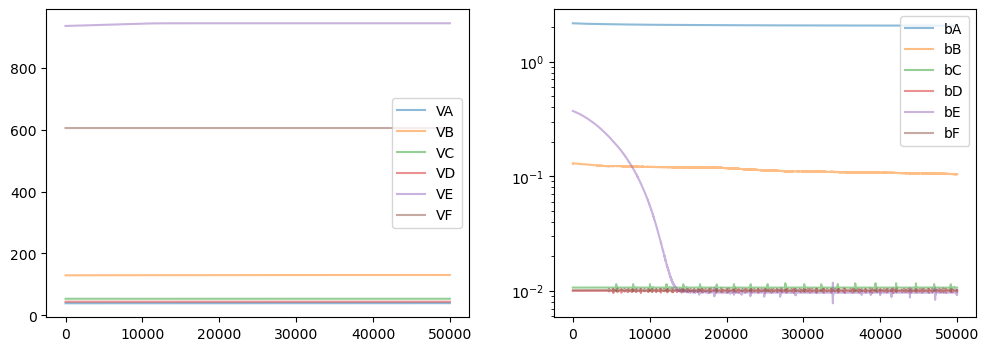

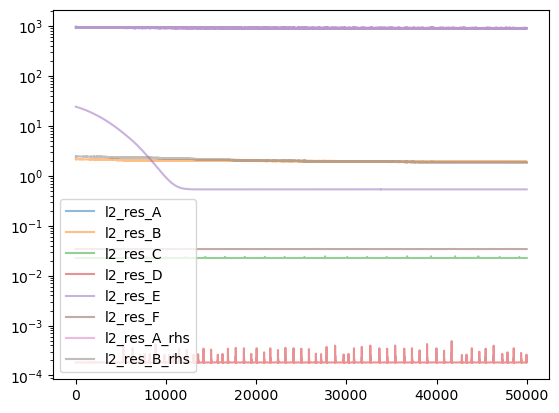

In [47]:
param_name = ["bA", "bB", "bC", "bD", "bE", "bF", "VA", "VB", "VC", "VD", "VE", "VF"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est2[-1,i] > 10:
        plt.plot(params_est2[:,i], label=n, alpha=.5)
        
plt.legend();
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est2[-1,i] <= 10:
        plt.plot(params_est2[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

for i, n in enumerate(names):
    plt.plot(losses2[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

In [41]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, inputs)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]
            #A_t = grad_A[:, 2]

            grad_B = tape2.gradient(Bg, inputs)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            #B_t = grad_B[:, 2]
            
#             grad_C = tape2.gradient(Cg, inputs)
#             C_t = grad_C[:, 2]
            
#             grad_D = tape2.gradient(Dg, inputs)
#             D_t = grad_D[:, 2]
            
#             grad_E = tape2.gradient(Eg, inputs)
#             E_t = grad_E[:, 2]
            
#             grad_F = tape2.gradient(Fg, inputs)
#             F_t = grad_F[:, 2]
            

        grad_A_x = tape.gradient(A_x, inputs)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, inputs)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, inputs)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, inputs)
        B_yy = grad_B_y[:, 1]
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy),
            tf.squeeze(Cg), 
            tf.squeeze(Dg), 
            tf.squeeze(Eg), 
            tf.squeeze(Fg))                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state():
        (A, A_xx, A_yy, 
         B, B_xx, B_yy, 
         C,  D,  E,  F, 
        ) = grads(pinn, obs_X)
        
        A_der = DA.numpy()*( to(A_xx) + to(A_yy))
        B_der = DB.numpy()*( to(B_xx) + to(B_yy))

        actual_A_der = DA.numpy()*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB.numpy()*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        A_der = A_der
        B_der = B_der

        A = c_restricted[0,:, : , -1]
        B = c_restricted[1,:, : , -1]

        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([to(A_t).T,  c_t[0,:, : , -1],  to(B_t).T,  c_t[1,:, : , -1]],
#                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
#                   figsize=(12, 3)); plt.tight_layout()
        plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
                   ["Actual A_t",  "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

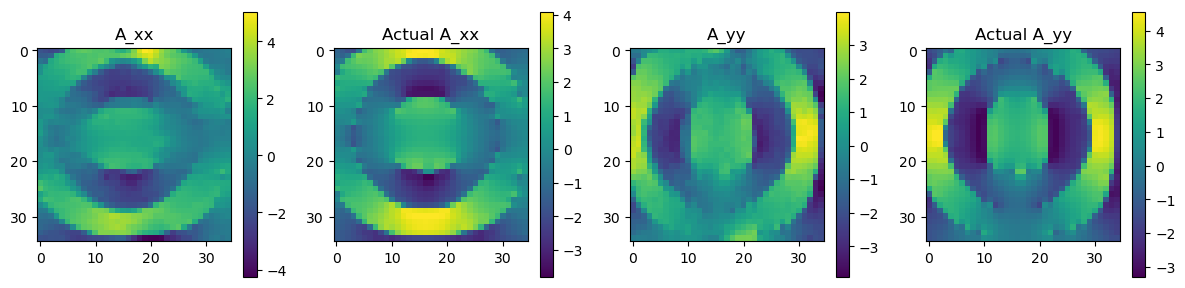

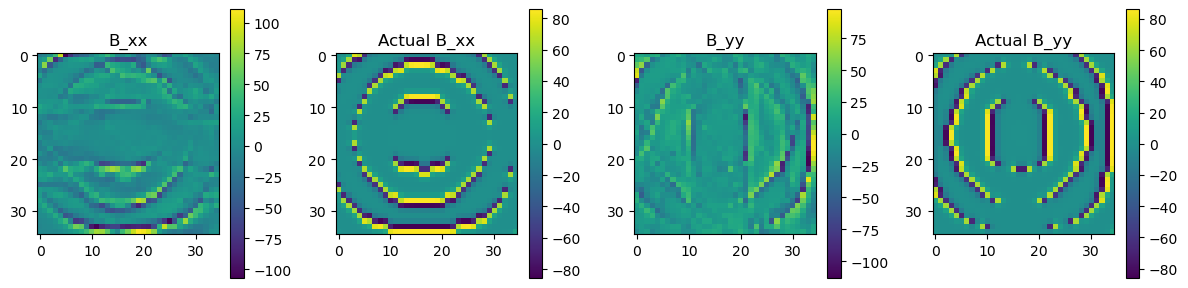

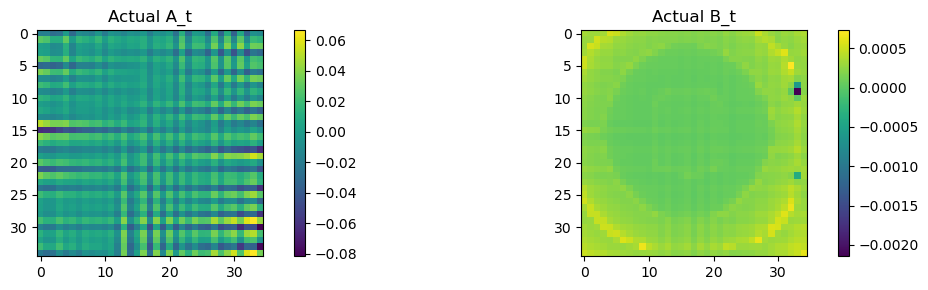

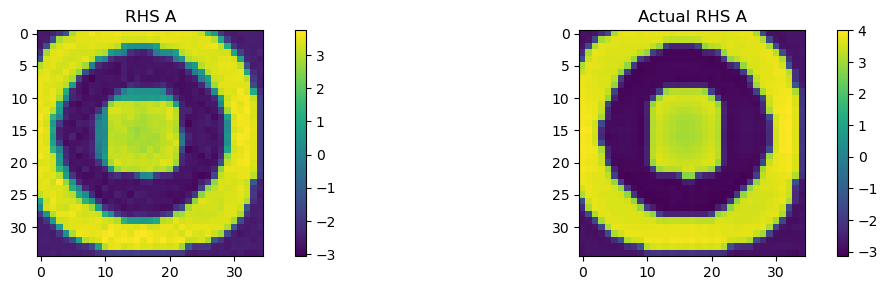

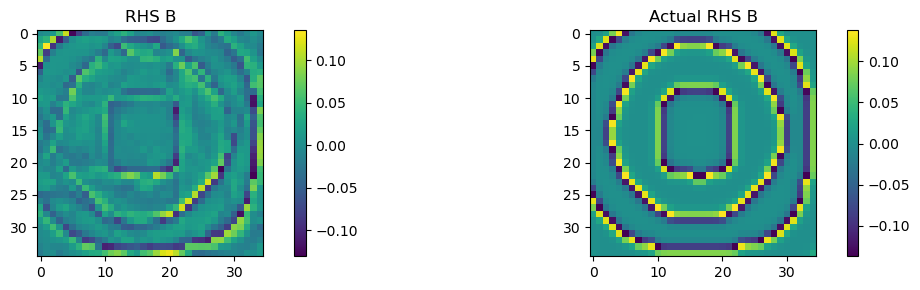

In [48]:
plot_state()

3105.5037


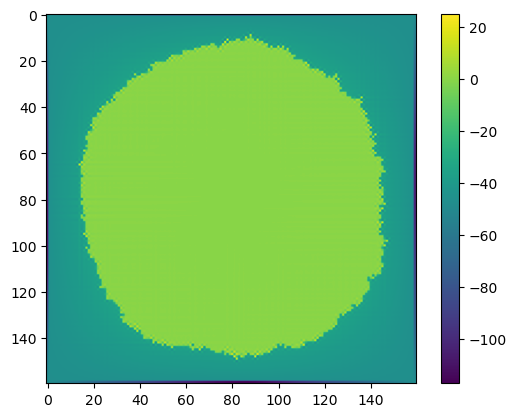

In [192]:
f_Ac = f_A.copy()
#f_Ac[f_Ac < 0] = -100
plt.imshow(f_Ac)
plt.colorbar()
print(np.sum(f_E**2))

In [142]:
(block_x, block_y)

(160, 160)